<a href="https://colab.research.google.com/github/ole-ksandra/IAD/blob/main/%D0%9F%D0%A04_%D0%A4%D0%91_%D0%B751%D0%BC%D0%BF_Oleksandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обробка текстових даних

preprocess → wordcloud → tf-idf → класифікація

https://www.kaggle.com/datasets/rmisra/news-category-dataset

In [ ]:
!pip install wordcloud


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


## Завантаження датасету




In [ ]:
import json
file_path = "News_Category_Dataset_v3.json"  # назва файлу як у Kaggle

rows = []
with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Пропускаємо битий рядок № {i}")

df = pd.DataFrame(rows)
df.head()


Пропускаємо битий рядок № 134481


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Перевіримо базову інформацію

In [ ]:
print("Розмір датасету:", df.shape)
print("\nСтовпці:")
print(df.columns.tolist())

print("\nПриклади категорій:")
print(df['category'].value_counts().head(10))


Розмір датасету: (134481, 6)

Стовпці:
['link', 'headline', 'category', 'short_description', 'authors', 'date']

Приклади категорій:
category
POLITICS          35602
ENTERTAINMENT     15576
HEALTHY LIVING     6694
QUEER VOICES       5031
SPORTS             4376
BUSINESS           4314
COMEDY             4202
PARENTS            3955
BLACK VOICES       3914
THE WORLDPOST      3664
Name: count, dtype: int64


## Формування тексту + очищення (передобробка)
Використаємо headline + short_description разом як текст, який будемо класифікувати.

In [ ]:
# Створюємо єдине текстове поле
df['headline'] = df['headline'].fillna('')
df['short_description'] = df['short_description'].fillna('')

df['text'] = df['headline'] + " " + df['short_description']

# Викидаємо порожні тексти
df = df[df['text'].str.strip() != ""].copy()

print("Після фільтрації:", df.shape)


Після фільтрації: (134476, 7)


Функція попередньої обробки

переведення до нижнього регістру,

видалення пунктуації та небуквенних символів,

видалення стоп-слів,

видалення дуже коротких слів

In [ ]:
stopwords = ENGLISH_STOP_WORDS  # вбудований список стоп-слів sklearn

def preprocess_text(text):
    # до нижнього регістру
    text = text.lower()
    # видаляємо все, що не букви та пробіли
    text = re.sub(r'[^a-z\s]', ' ', text)
    # прибираємо зайві пробіли
    text = re.sub(r'\s+', ' ', text).strip()
    # токенізація
    tokens = text.split()
    # видалення стоп-слів та дуже коротких слів
    tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
    return " ".join(tokens)

# застосовуємо до всього датасету
df['clean_text'] = df['text'].apply(preprocess_text)

# Перевіряємо, скільки прикладів у кожній категорії
cat_counts = df['category'].value_counts()
print("Найрідкісніші категорії:")
print(cat_counts.sort_values().head(10))

# Забираємо категорії, де менше 2 документів
min_count = 2
valid_cats = cat_counts[cat_counts >= min_count].index
df = df[df['category'].isin(valid_cats)].copy()

print("\nПісля фільтрації:")
print(df['category'].value_counts().tail(10))


df[['category', 'text', 'clean_text']].head()


Найрідкісніші категорії:
category
DIVORCE            33
WEDDINGS           41
CULTURE & ARTS     51
MONEY              70
ENVIRONMENT       130
HOME & LIVING     149
FOOD & DRINK      205
PARENTING         235
STYLE & BEAUTY    253
WELLNESS          333
Name: count, dtype: int64

Після фільтрації:
category
WELLNESS          333
STYLE & BEAUTY    253
PARENTING         235
FOOD & DRINK      205
HOME & LIVING     149
ENVIRONMENT       130
MONEY              70
CULTURE & ARTS     51
WEDDINGS           41
DIVORCE            33
Name: count, dtype: int64


,category,text,clean_text
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,million americans roll sleeves omicron targete...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",american airlines flyer charged banned life pu...
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,funniest tweets cats dogs week sept dog don un...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,funniest tweets parents week sept accidentally...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cops black bird watcher loses law...


## WordCloud для кількох категорій

візьмемо, наприклад, 4 найпоширеніші

In [ ]:
cat_counts = df['category'].value_counts()
print(cat_counts.head(20))

category
POLITICS          35601
ENTERTAINMENT     15576
HEALTHY LIVING     6694
QUEER VOICES       5030
SPORTS             4376
BUSINESS           4313
COMEDY             4202
PARENTS            3955
BLACK VOICES       3914
THE WORLDPOST      3664
WOMEN              3572
WORLD NEWS         3299
CRIME              3059
MEDIA              2943
WEIRD NEWS         2777
IMPACT             2634
GREEN              2622
WORLDPOST          2578
RELIGION           2577
TRAVEL             2256
Name: count, dtype: int64


In [ ]:
top_categories = df['category'].value_counts().head(4).index.tolist()
print("Вибрані категорії:", top_categories)


Вибрані категорії: ['POLITICS', 'ENTERTAINMENT', 'HEALTHY LIVING', 'QUEER VOICES']


візуалізацію найбільш поширених слів у кожному класі.

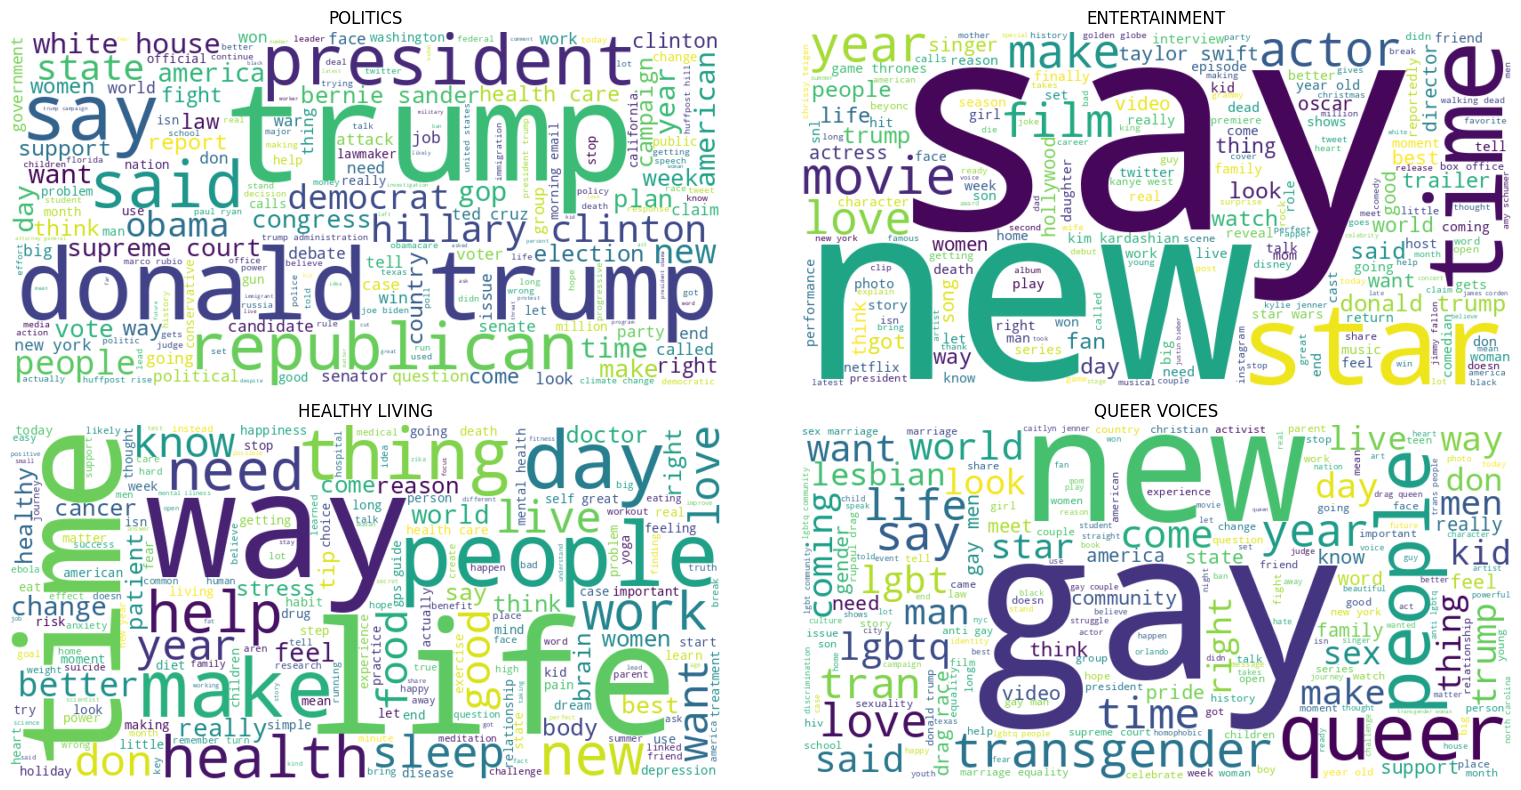

In [ ]:
plt.figure(figsize=(16, 8))

for i, cat in enumerate(top_categories, start=1):
    class_texts = df[df['category'] == cat]['clean_text']
    full_text = " ".join(class_texts)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200
    ).generate(full_text)

    plt.subplot(2, 2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(cat)

plt.tight_layout()
plt.show()


додаємо фільтрацію по кількох класах

In [ ]:
# Обираємо кілька найпоширеніших категорій (наприклад, 5)
selected_categories = ['POLITICS',
                       'ENTERTAINMENT',
                       'WORLD NEWS',
                       'QUEER VOICES',
                       'SPORTS']

print("Обрані категорії:", selected_categories)

# Створюємо новий датафрейм тільки з цими категоріями
df_small = df[df['category'].isin(selected_categories)].copy()

print("Розмір нового датасету:", df_small.shape)
print(df_small['category'].value_counts())


Обрані категорії: ['POLITICS', 'ENTERTAINMENT', 'WORLD NEWS', 'QUEER VOICES', 'SPORTS']
Розмір нового датасету: (63882, 8)
category
POLITICS         35601
ENTERTAINMENT    15576
QUEER VOICES      5030
SPORTS            4376
WORLD NEWS        3299
Name: count, dtype: int64


## Векторизація текстів (TF-IDF)

In [ ]:
X_text = df_small['clean_text']
y = df_small['category']

print("Приклад очищеного тексту:")
print(X_text.iloc[0])


Приклад очищеного тексту:
puerto ricans desperate water hurricane fiona rampage half million people remained water service days storm lashed territory


In [ ]:
tfidf = TfidfVectorizer(
    max_features=20000,     # щоб не роздувати ознаки
    ngram_range=(1, 2),     # уніграми + біграми
    min_df=5,               # ігнорувати дуже рідкісні
    max_df=0.8              # і дуже часті "сміттєві" слова
)

X = tfidf.fit_transform(X_text)
print("Форма матриці TF-IDF:", X.shape)


Форма матриці TF-IDF: (63882, 20000)


## Train / test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y   # щоб пропорції класів збереглися
)

print("Розмір train:", X_train.shape[0])
print("Розмір test :", X_test.shape[0])


Розмір train: 51105
Розмір test : 12777


## Класифікація текстів + оцінка якості

Візьмемо логістичну регресію (добре працює з TF-IDF):

In [ ]:
clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Оцінка:

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8801753150191751

Classification report:
               precision    recall  f1-score   support

ENTERTAINMENT       0.87      0.88      0.88      3115
     POLITICS       0.89      0.97      0.92      7121
 QUEER VOICES       0.88      0.66      0.76      1006
       SPORTS       0.88      0.72      0.79       875
   WORLD NEWS       0.84      0.49      0.62       660

     accuracy                           0.88     12777
    macro avg       0.87      0.74      0.79     12777
 weighted avg       0.88      0.88      0.87     12777


Confusion matrix:
[[2752  293   25   38    7]
 [ 129 6873   46   30   43]
 [ 148  174  668   11    5]
 [ 109  123   10  628    5]
 [  30  289    7    9  325]]
